# Python HANA ML API

<div class="alert alert-block alert-info">
<b>Building a Predictive Model for Insurance Fraud Detection.</b> <br>
</div>

### Create an HANA Dataframe containing historical Insurance Claims

In [21]:
# Connect using the HANA secure user store 
from hana_ml import dataframe as hd
conn = hd.ConnectionContext(userkey='MLMDA_KEY')
# Get Training Data
sql_cmd = 'SELECT * FROM "APL_SAMPLES"."AUTO_CLAIMS_FRAUD" ORDER BY CLAIM_ID'
training_data = hd.DataFrame(conn, sql_cmd)
training_data.head(8).collect()

,CLAIM_ID,DAYS_TO_REPORT,BODILY_INJURY_AMOUNT,PROPERTY_DAMAGE,PREVIOUS_CLAIMS,PAYMENT_METHOD,IS_REAR_END_COLLISION,PREM_AMOUNT,AGE,GENDER,MARITAL_STATUS,INCOME_ESTIMATE,INCOME_CATEGORY,POLICY_HOLDER,IS_FRAUD
0,CL_0000765,8,0,1957,0,CC,No,Safedriving_discount,52,Male,Single,15906.0,15,Y,No
1,CL_0000832,30,2541,3843,0,CC,No,Safedriving_discount,85,Female,Single,91100.6,75,N,No
2,CL_0002015,4,0,25719,0,CC,No,Standard,45,Male,Married,67085.4,50,N,No
3,CL_0002854,0,0,83,1,Auto,No,Standard,75,Male,Married,49561.0,35,N,No
4,CL_0002869,22,0,1264,0,CC,Yes,Standard,48,Female,Married,39598.7,35,N,No
5,CL_0003400,3,9903,7333,0,Auto,No,Safedriving_discount,41,Male,Single,48271.8,35,N,Yes
6,CL_0005084,14,0,1882,0,CC,No,Safedriving_discount,26,Female,Single,76074.1,75,Y,No
7,CL_0005346,12,15399,8864,0,Auto,No,Standard,73,Male,Married,61438.2,50,N,No


### Build a Classification model with the APL module

In [22]:
# Create Model  
from hana_ml.algorithms.apl.classification import AutoClassifier
model = AutoClassifier(conn_context=conn, variable_auto_selection = True, polynomial_degree =1 )
# Train the model
model.set_params(cutting_strategy = 'random with no test')
model.fit(training_data, label='IS_FRAUD', key='CLAIM_ID')
# Debrief the trained model 
import pandas as pd
print('\r\n\x1b[1m'+ 'MODEL PERFORMANCE' + '\x1b[0m')
d = model.get_performance_metrics()
df = pd.DataFrame(list(d.items()), columns=["Metric", "Value"])
df.loc[df.Metric == 'AUC'].style.hide_index()


MODEL PERFORMANCE


Metric,Value
AUC,0.8098


In [23]:
print('\r\n\x1b[1m'+ 'VARIABLES IMPORTANCE' + '\x1b[0m')
d = model.get_feature_importances() 
df = pd.DataFrame(list(d.items()), columns=["Variable", "Contribution"])
df['Contribution'] = df['Contribution'].astype(float)
df['Cumulative'] = df['Contribution'].cumsum()
df['Contribution'] = df['Contribution'].round(4)*100
df['Cumulative'] = df['Cumulative'].round(4)*100
non_zero = df['Contribution'] != 0
dfs = df[non_zero].sort_values(by=['Contribution'], ascending=False)
dfs.style.hide_index()


VARIABLES IMPORTANCE


Variable,Contribution,Cumulative
BODILY_INJURY_AMOUNT,52.62,52.62
AGE,10.48,63.1
DAYS_TO_REPORT,10.4,73.5
INCOME_CATEGORY,9.76,83.26
INCOME_ESTIMATE,6.83,90.09
PAYMENT_METHOD,6.07,96.16
GENDER,3.84,100


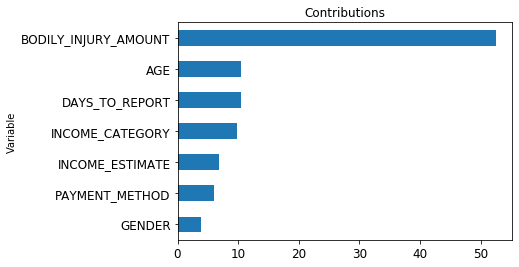

In [24]:
# Graph
import matplotlib.pyplot as plt
c_title = "Contributions" 
dfs = dfs.sort_values(by=['Contribution'], ascending=True)
dfs.plot(kind='barh', x='Variable', y='Contribution', title=c_title, legend=False, fontsize=12)
plt.show()

### Make Predictions on New Claims

In [25]:
# Get New Claims  
new_data = conn.table('AUTO_CLAIMS_NEW', schema='APL_SAMPLES')
# Apply Trained Model
df = model.predict(new_data).collect()
df.columns = ['Claim Id', 'Prediction', 'Probability', 'Actual']
df.head(8).style.format({'Probability': '{:,.2%}'.format}).hide_index()

Claim Id,Prediction,Probability,Actual
CL_0959524,No,95.58%,None
CL_0959946,No,100.00%,None
CL_0960121,No,80.01%,None
CL_0960195,No,96.04%,None
CL_0960294,No,74.61%,None
CL_0960379,Yes,33.43%,None
CL_0960411,No,100.00%,None
CL_0960946,No,100.00%,None
